# Plotting cross section ratios as a function of Bjorken-x

<h2 style="text-align: center; color: orange">Changing Delta</h2>

In [12]:
import uproot, time, sys
start_time = time.time()
sys.path.append('/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2')
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy import stats
from numba import njit, prange
import multiprocessing
import concurrent.futures
from common_functions import read_report, ImportRadcor, target_info, root_hist_to_numpy, csb, jra_nprat, datahist_from_array, mchist_from_array, cereff, baja, E, leaky_cauldron
from common_functions import LD2_dict, C12_dict, Dummy_dict, Fe54_dict, Ca40_dict, Be9_dict, Ca48_dict, B10_dict, B11_dict, He4_dict, He3_dict, C12_dict_l2, delta_correction
from common_functions import Sn119_dict, Ti48_dict, Ag108_dict, Th232_dict, Ni58_dict, Ni64_dict, Li7_dict, Li6_dict, Al27_dict, Cu63_dict, Au197_dict, cafe_report_path, tinfo_path

\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{MC}
\end{equation}

In [13]:
folder = 'dc'
leaky = 1
ntg = 'He3' # What is the nuclei in numerator?
nsimstring = ntg.lower()
print("nsimstring", nsimstring)
dtg = 'LD2' # What is the nuclei in denominator?
dsimstring = dtg.lower()
print("dsimstring", dsimstring)
ald = 'Dummy' # Aluminium dummy target
dang = 20.0 # What is your desired angle?
dmom = [2.42, 2.71, 3.04, 3.40, 3.81, 4.27, 4.78, 5.36, 5.878, 6.6] # What are your desired central momenta (just the magnitude)
bin_per_mom = 16 # How many bins per momentum?
bin_num = bin_per_mom * len(dmom) # Total number of bins in the combined histogram

# Kinematic variables
ts = dang # Spectrometer angle
Z, A = target_info[ntg][0], target_info[ntg][1]  # Target
thick = target_info[ntg][2] # g/cm2. From Cameron's target sheet column 'R'
ep_min = {}
ep_max = {}

# Constants
Ei, Mp = 10.54, 0.93825 # Beam energcountsy and proton mass in GeV
N_A, Q_E = 6.02e+23, 1.60e-19 # Avogadro's number and charge in 1 electron
dpp_up, dpp_down = 10.0, -10.0 # Momentum acceptance upper and lower limit
cos_ts = np.cos(np.deg2rad(ts))
sin_ts = np.sin(np.deg2rad(ts))

for momentum in dmom:
    ep_min[momentum] = momentum * (1 + 0.01 * dpp_down)
    ep_max[momentum] = momentum * (1 + 0.01 * dpp_up)
    phi_up, phi_down, theta_up, theta_down = 100.0, -100.0, 65.0, -65.0 # mrad
    domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  # diff solid angle in sr
    sim_charge = 1.
    lumin = thick * sim_charge / A * N_A / Q_E * 1e-39

nsimstring he3
dsimstring ld2


<h1 align="center">DATA WORK FOR NTG</h1>

In [14]:
# Define the data cuts
data_cut = "-8 < H_gtr_dp && H_gtr_dp < 8 && H_cal_etottracknorm > 0.7 && abs(H_gtr_ph) < 0.032 && abs(H_gtr_th) < 0.085 && H_cer_npeSum > 2 && H_bcm_CurrentFlag == 1"

target_dict_name = f'{ntg}_dict'
# target_dict_name = f'{ntg}_dict_l2' # To read ladder 2 carbon runs
target_dict = globals()[target_dict_name]
delta_hist = {}
theta_dict = {}
eff_weight = {}
data_delta = np.linspace(-8.0, 8.0, bin_per_mom + 1)

for momentum in dmom:
    files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in target_dict[momentum]]
    branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
    electrons = uproot.concatenate(files, branches)

    data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
    dp_cut = electrons['H_gtr_dp'][data_cut]
    theta_cut = electrons['H_gtr_th'][data_cut]
    phi_cut = electrons['H_gtr_ph'][data_cut]

    # Cherenkov efficiency correction
    eff_weight[momentum] = 1 / cereff(dp_cut)

    theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
    delta_hist[momentum] = np.array(dp_cut)

Analyzing leaky runs
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
Target boiling correction applied for cryo target He3
[1.3069087  1.26614024 1.23960078 1.250952   1.2216147  1.20490763
 1.20690608 1.19059284 1.1856033  1.16964292 1.14101333 1.14021138
 1.11655388 1.09241521 1.07469213 1.04750605]


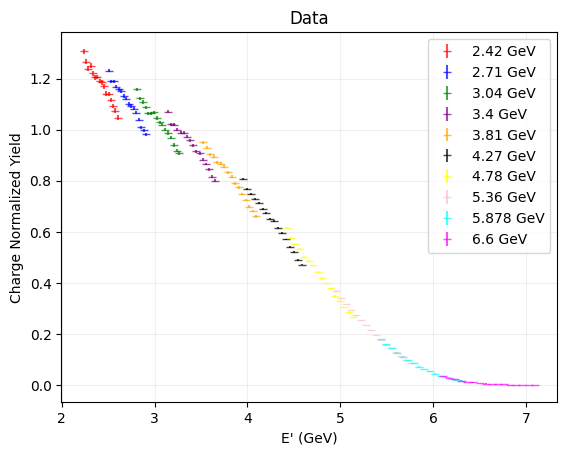

In [15]:
# Calculate the charge normalized yield and the uncertainty per bin
if ntg == 'He3' and leaky == 1:
    print("Analyzing leaky runs")
    delta_bin_contents_2p42_ntg, delta_bin_errors_2p42_ntg = datahist_from_array(delta_hist[2.42], 2.42, data_delta, ntg, eff_weight[2.42] / 1.0015)
    delta_bin_contents_2p71_ntg, delta_bin_errors_2p71_ntg = datahist_from_array(delta_hist[2.71], 2.71, data_delta, ntg, eff_weight[2.71] / 1.0537)
    delta_bin_contents_3p04_ntg, delta_bin_errors_3p04_ntg = datahist_from_array(delta_hist[3.04], 3.04, data_delta, ntg, eff_weight[3.04] / 1.0539)
    delta_bin_contents_3p4_ntg, delta_bin_errors_3p4_ntg = datahist_from_array(delta_hist[3.4], 3.4, data_delta, ntg, eff_weight[3.4] / 1.0818)
    delta_bin_contents_3p81_ntg, delta_bin_errors_3p81_ntg = datahist_from_array(delta_hist[3.81], 3.81, data_delta, ntg, eff_weight[3.81] / 1.0838)
    delta_bin_contents_4p27_ntg, delta_bin_errors_4p27_ntg = datahist_from_array(delta_hist[4.27], 4.27, data_delta, ntg, eff_weight[4.27] / 1.1104)
    delta_bin_contents_4p78_ntg, delta_bin_errors_4p78_ntg = datahist_from_array(delta_hist[4.78], 4.78, data_delta, ntg, eff_weight[4.78] / 1.1141)
    delta_bin_contents_5p36_ntg, delta_bin_errors_5p36_ntg = datahist_from_array(delta_hist[5.36], 5.36, data_delta, ntg, eff_weight[5.36] / 1.1810)
    delta_bin_contents_5p878_ntg, delta_bin_errors_5p878_ntg = datahist_from_array(delta_hist[5.878], 5.878, data_delta, ntg, eff_weight[5.878] / 1.18045)
    delta_bin_contents_6p6_ntg, delta_bin_errors_6p6_ntg = datahist_from_array(delta_hist[6.6], 6.6, data_delta, ntg, eff_weight[6.6] / 1.5401)
else:
    delta_bin_contents_2p42_ntg, delta_bin_errors_2p42_ntg = datahist_from_array(delta_hist[2.42], 2.42, data_delta, ntg, eff_weight[2.42])
    delta_bin_contents_2p71_ntg, delta_bin_errors_2p71_ntg = datahist_from_array(delta_hist[2.71], 2.71, data_delta, ntg, eff_weight[2.71])
    delta_bin_contents_3p04_ntg, delta_bin_errors_3p04_ntg = datahist_from_array(delta_hist[3.04], 3.04, data_delta, ntg, eff_weight[3.04])
    delta_bin_contents_3p4_ntg, delta_bin_errors_3p4_ntg = datahist_from_array(delta_hist[3.4], 3.4, data_delta, ntg, eff_weight[3.4])
    delta_bin_contents_3p81_ntg, delta_bin_errors_3p81_ntg = datahist_from_array(delta_hist[3.81], 3.81, data_delta, ntg, eff_weight[3.81])
    delta_bin_contents_4p27_ntg, delta_bin_errors_4p27_ntg = datahist_from_array(delta_hist[4.27], 4.27, data_delta, ntg, eff_weight[4.27])
    delta_bin_contents_4p78_ntg, delta_bin_errors_4p78_ntg = datahist_from_array(delta_hist[4.78], 4.78, data_delta, ntg, eff_weight[4.78])
    delta_bin_contents_5p36_ntg, delta_bin_errors_5p36_ntg = datahist_from_array(delta_hist[5.36], 5.36, data_delta, ntg, eff_weight[5.36])
    delta_bin_contents_5p878_ntg, delta_bin_errors_5p878_ntg = datahist_from_array(delta_hist[5.878], 5.878, data_delta, ntg, eff_weight[5.878])
    delta_bin_contents_6p6_ntg, delta_bin_errors_6p6_ntg = datahist_from_array(delta_hist[6.6], 6.6, data_delta, ntg, eff_weight[6.6])

_, delta_bin_edges_2p42 = np.histogram(delta_hist[2.42], bins = data_delta)
_, delta_bin_edges_2p71 = np.histogram(delta_hist[2.71], bins = data_delta)
_, delta_bin_edges_3p04 = np.histogram(delta_hist[3.04], bins = data_delta)
_, delta_bin_edges_3p4 = np.histogram(delta_hist[3.4], bins = data_delta)
_, delta_bin_edges_3p81 = np.histogram(delta_hist[3.81], bins = data_delta)
_, delta_bin_edges_4p27 = np.histogram(delta_hist[4.27], bins = data_delta)
_, delta_bin_edges_4p78 = np.histogram(delta_hist[4.78], bins = data_delta)
_, delta_bin_edges_5p36 = np.histogram(delta_hist[5.36], bins = data_delta)
_, delta_bin_edges_5p878 = np.histogram(delta_hist[5.878], bins = data_delta)
_, delta_bin_edges_6p6 = np.histogram(delta_hist[6.6], bins = data_delta)

delta_bin_centers_2p42 = (delta_bin_edges_2p42[:-1] + delta_bin_edges_2p42[1:]) / 2
delta_bin_centers_2p71 = (delta_bin_edges_2p71[:-1] + delta_bin_edges_2p71[1:]) / 2
delta_bin_centers_3p04 = (delta_bin_edges_3p04[:-1] + delta_bin_edges_3p04[1:]) / 2
delta_bin_centers_3p4 = (delta_bin_edges_3p4[:-1] + delta_bin_edges_3p4[1:]) / 2
delta_bin_centers_3p81 = (delta_bin_edges_3p81[:-1] + delta_bin_edges_3p81[1:]) / 2
delta_bin_centers_4p27 = (delta_bin_edges_4p27[:-1] + delta_bin_edges_4p27[1:]) / 2
delta_bin_centers_4p78 = (delta_bin_edges_4p78[:-1] + delta_bin_edges_4p78[1:]) / 2
delta_bin_centers_5p36 = (delta_bin_edges_5p36[:-1] + delta_bin_edges_5p36[1:]) / 2
delta_bin_centers_5p878 = (delta_bin_edges_5p878[:-1] + delta_bin_edges_5p878[1:]) / 2
delta_bin_centers_6p6 = (delta_bin_edges_6p6[:-1] + delta_bin_edges_6p6[1:]) / 2

binned_eprime_bin_centers_2p42 = 2.42 * (1 + 0.01 * delta_bin_centers_2p42)
binned_eprime_bin_centers_2p71 = 2.71 * (1 + 0.01 * delta_bin_centers_2p71)
binned_eprime_bin_centers_3p04 = 3.04 * (1 + 0.01 * delta_bin_centers_3p04)
binned_eprime_bin_centers_3p4 = 3.4 * (1 + 0.01 * delta_bin_centers_3p4)
binned_eprime_bin_centers_3p81 = 3.81 * (1 + 0.01 * delta_bin_centers_3p81)
binned_eprime_bin_centers_4p27 = 4.27 * (1 + 0.01 * delta_bin_centers_4p27)
binned_eprime_bin_centers_4p78 = 4.78 * (1 + 0.01 * delta_bin_centers_4p78)
binned_eprime_bin_centers_5p36 = 5.36 * (1 + 0.01 * delta_bin_centers_5p36)
binned_eprime_bin_centers_5p878 = 5.878 * (1 + 0.01 * delta_bin_centers_5p878)
binned_eprime_bin_centers_6p6 = 6.6 * (1 + 0.01 * delta_bin_centers_6p6)

# Calculate the charge symmetric background fraction per bin
csb_frac_2p42_ntg = csb(binned_eprime_bin_centers_2p42, ntg, dang)
csb_frac_2p71_ntg = csb(binned_eprime_bin_centers_2p71, ntg, dang)
csb_frac_3p04_ntg = csb(binned_eprime_bin_centers_3p04, ntg, dang)
csb_frac_3p4_ntg = csb(binned_eprime_bin_centers_3p4, ntg, dang)
csb_frac_3p81_ntg = csb(binned_eprime_bin_centers_3p81, ntg, dang)
csb_frac_4p27_ntg = csb(binned_eprime_bin_centers_4p27, ntg, dang)
csb_frac_4p78_ntg = csb(binned_eprime_bin_centers_4p78, ntg, dang)
csb_frac_5p36_ntg = csb(binned_eprime_bin_centers_5p36, ntg, dang)
csb_frac_5p878_ntg = csb(binned_eprime_bin_centers_5p878, ntg, dang)
csb_frac_6p6_ntg = csb(binned_eprime_bin_centers_6p6, ntg, dang)

# Subtract the charge symmetric background fraction from the total yield
subtracted_bin_contents_2p42_ntg = delta_bin_contents_2p42_ntg * (1 - csb_frac_2p42_ntg)
subtracted_bin_contents_2p71_ntg = delta_bin_contents_2p71_ntg * (1 - csb_frac_2p71_ntg)
subtracted_bin_contents_3p04_ntg = delta_bin_contents_3p04_ntg * (1 - csb_frac_3p04_ntg)
subtracted_bin_contents_3p4_ntg = delta_bin_contents_3p4_ntg * (1 - csb_frac_3p4_ntg)
subtracted_bin_contents_3p81_ntg = delta_bin_contents_3p81_ntg * (1 - csb_frac_3p81_ntg)
subtracted_bin_contents_4p27_ntg = delta_bin_contents_4p27_ntg * (1 - csb_frac_4p27_ntg)
subtracted_bin_contents_4p78_ntg = delta_bin_contents_4p78_ntg * (1 - csb_frac_4p78_ntg)
subtracted_bin_contents_5p36_ntg = delta_bin_contents_5p36_ntg * (1 - csb_frac_5p36_ntg)
subtracted_bin_contents_5p878_ntg = delta_bin_contents_5p878_ntg * (1 - csb_frac_5p878_ntg)
subtracted_bin_contents_6p6_ntg = delta_bin_contents_6p6_ntg * (1 - csb_frac_6p6_ntg)

# Add the errors in quadrature
subtracted_bin_errors_2p42_ntg = delta_bin_errors_2p42_ntg * (1 - csb_frac_2p42_ntg)
subtracted_bin_errors_2p71_ntg = delta_bin_errors_2p71_ntg * (1 - csb_frac_2p71_ntg)
subtracted_bin_errors_3p04_ntg = delta_bin_errors_3p04_ntg * (1 - csb_frac_3p04_ntg)
subtracted_bin_errors_3p4_ntg = delta_bin_errors_3p4_ntg * (1 - csb_frac_3p4_ntg)
subtracted_bin_errors_3p81_ntg = delta_bin_errors_3p81_ntg * (1 - csb_frac_3p81_ntg)
subtracted_bin_errors_4p27_ntg = delta_bin_errors_4p27_ntg * (1 - csb_frac_4p27_ntg)
subtracted_bin_errors_4p78_ntg = delta_bin_errors_4p78_ntg * (1 - csb_frac_4p78_ntg)
subtracted_bin_errors_5p36_ntg = delta_bin_errors_5p36_ntg * (1 - csb_frac_5p36_ntg)
subtracted_bin_errors_5p878_ntg = delta_bin_errors_5p878_ntg * (1 - csb_frac_5p878_ntg)
subtracted_bin_errors_6p6_ntg = delta_bin_errors_6p6_ntg * (1 - csb_frac_6p6_ntg)

# fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
fig, ax = plt.subplots()
ax.errorbar(binned_eprime_bin_centers_2p42, delta_bin_contents_2p42_ntg, yerr = subtracted_bin_errors_2p42_ntg, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV')
ax.errorbar(binned_eprime_bin_centers_2p71, delta_bin_contents_2p71_ntg, yerr = subtracted_bin_errors_2p71_ntg, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
ax.errorbar(binned_eprime_bin_centers_3p04, delta_bin_contents_3p04_ntg, yerr = subtracted_bin_errors_3p04_ntg, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
ax.errorbar(binned_eprime_bin_centers_3p4, delta_bin_contents_3p4_ntg, yerr = subtracted_bin_errors_3p4_ntg, fmt = '_', color = 'purple', alpha = 0.7, label = '3.4 GeV')
ax.errorbar(binned_eprime_bin_centers_3p81, delta_bin_contents_3p81_ntg, yerr = subtracted_bin_errors_3p81_ntg, fmt = '_', color = 'orange', alpha = 0.7, label = '3.81 GeV')
ax.errorbar(binned_eprime_bin_centers_4p27, delta_bin_contents_4p27_ntg, yerr = subtracted_bin_errors_4p27_ntg, fmt = '_', color = 'black', alpha = 0.7, label = '4.27 GeV')
ax.errorbar(binned_eprime_bin_centers_4p78, delta_bin_contents_4p78_ntg, yerr = subtracted_bin_errors_4p78_ntg, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.78 GeV')
ax.errorbar(binned_eprime_bin_centers_5p36, delta_bin_contents_5p36_ntg, yerr = subtracted_bin_errors_5p36_ntg, fmt = '_', color = 'pink', alpha = 0.7, label = '5.36 GeV')
ax.errorbar(binned_eprime_bin_centers_5p878, delta_bin_contents_5p878_ntg, yerr = subtracted_bin_errors_5p878_ntg, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
ax.errorbar(binned_eprime_bin_centers_6p6, delta_bin_contents_6p6_ntg, yerr = subtracted_bin_errors_6p6_ntg, fmt = '_', color = 'magenta', alpha = 0.7, label = '6.6 GeV')
ax.set_ylabel('Charge Normalized Yield')
ax.set_xlabel('E\' (GeV)')
ax.set_title('Data')
ax.legend()
# ax.set_yscale('log')
ax.grid(alpha = 0.2)
# fig.savefig(f'{folder}/{nsimstring}_{dsimstring}_newyield.pdf')
print(delta_bin_contents_2p42_ntg)

<h1 align = 'center'> TARGET SPECIFIC DATA YIELD CORRECTION</h1>

Performing Aluminum cell wall subtraction


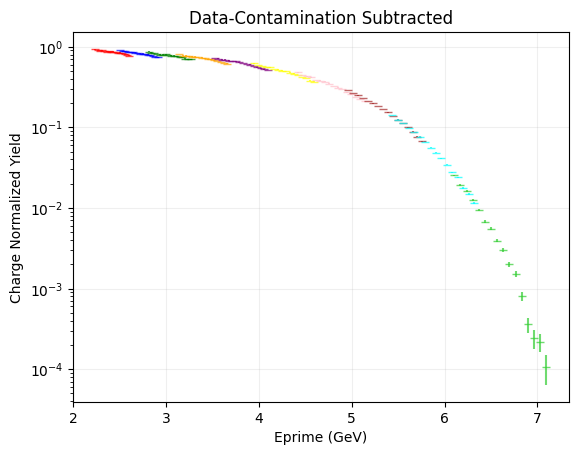

In [16]:
if ntg == 'Ca48':
    print("Correcting for Ca40 contamination in Ca48 target")
    C = 0.113 # Ratio of Ca40 contamination in Ca48 target to Ca40 target
    cont_tg = 'Ca40'

elif ntg == 'B10':
    print("Correcting for C12 contamination in B10 target")
    C = 0.231 # Ratio of C12 contamination in B10 target to C12 target
    cont_tg = 'C12'

elif ntg == 'B11':
    print("Correcting for C12 contamination in B11 target")
    C = 0.236 # Ratio of C12 contamination in B11 target to C12 target
    cont_tg = 'C12'

elif ntg == 'He3' or ntg == 'LD2':
    print("Performing Aluminum cell wall subtraction")
    C = 0.2165 # Mean of Ratio of upstream & downstream dummy to target cell thickness
    cont_tg = ald
    
else:
    print("No contamination correction needed")
    C = 0

if C != 0:
    cont_dict_name = f'{cont_tg}_dict' # Dictionary containing the runs for the contaminant
    cont_dict = globals()[cont_dict_name]    
    for momentum in dmom:
        files = [f'/Volumes/smriti/xem2/ROOTfiles/HMS_{run}_skim.root' for run in cont_dict[momentum]]
        branches = ['H_gtr_dp', 'H_cal_etottracknorm', 'H_gtr_ph', 'H_gtr_th', 'H_cer_npeSum', 'H_bcm_CurrentFlag']
        electrons = uproot.concatenate(files, branches)

        data_cut = (np.abs(electrons['H_gtr_dp']) < 8) & (electrons['H_cal_etottracknorm'] > 0.7) & (np.abs(electrons['H_gtr_ph']) < 0.032) & (np.abs(electrons['H_gtr_th']) < 0.085) & (electrons['H_cer_npeSum'] > 2) & (electrons['H_bcm_CurrentFlag'] == 1)
        dp_cut = electrons['H_gtr_dp'][data_cut]
        theta_cut = electrons['H_gtr_th'][data_cut]
        phi_cut = electrons['H_gtr_ph'][data_cut]

        eff_weight[momentum] = 1 / cereff(dp_cut) # Cherenkov efficiency correction

        theta_dict[momentum] = np.rad2deg(np.arccos((cos_ts + phi_cut * sin_ts) / np.sqrt(1 + theta_cut * theta_cut + phi_cut * phi_cut)))
        delta_hist[momentum] = np.array(dp_cut)

    # Get yield and yield error from array
    contaminant_eprime_bin_contents_2p42, contaminant_eprime_bin_errors_2p42 = datahist_from_array(delta_hist[2.42], 2.42, data_delta, cont_tg, eff_weight[2.42])
    contaminant_eprime_bin_contents_2p71, contaminant_eprime_bin_errors_2p71 = datahist_from_array(delta_hist[2.71], 2.71, data_delta, cont_tg, eff_weight[2.71])
    contaminant_eprime_bin_contents_3p04, contaminant_eprime_bin_errors_3p04 = datahist_from_array(delta_hist[3.04], 3.04, data_delta, cont_tg, eff_weight[3.04])
    contaminant_eprime_bin_contents_3p4, contaminant_eprime_bin_errors_3p4 = datahist_from_array(delta_hist[3.4], 3.4, data_delta, cont_tg, eff_weight[3.4])
    contaminant_eprime_bin_contents_3p81, contaminant_eprime_bin_errors_3p81 = datahist_from_array(delta_hist[3.81], 3.81, data_delta, cont_tg, eff_weight[3.81])
    contaminant_eprime_bin_contents_4p27, contaminant_eprime_bin_errors_4p27 = datahist_from_array(delta_hist[4.27], 4.27, data_delta, cont_tg, eff_weight[4.27])
    contaminant_eprime_bin_contents_4p78, contaminant_eprime_bin_errors_4p78 = datahist_from_array(delta_hist[4.78], 4.78, data_delta, cont_tg, eff_weight[4.78])
    contaminant_eprime_bin_contents_5p36, contaminant_eprime_bin_errors_5p36 = datahist_from_array(delta_hist[5.36], 5.36, data_delta, cont_tg, eff_weight[5.36])
    contaminant_eprime_bin_contents_5p878, contaminant_eprime_bin_errors_5p878 = datahist_from_array(delta_hist[5.878], 5.878, data_delta, cont_tg, eff_weight[5.878])
    contaminant_eprime_bin_contents_6p6, contaminant_eprime_bin_errors_6p6 = datahist_from_array(delta_hist[6.6], 6.6, data_delta, cont_tg, eff_weight[6.6])

    # Calculate the charge symmetric background fraction per bin for contaminant
    csb_frac_2p42_cont = csb(binned_eprime_bin_centers_2p42, cont_tg, dang)
    csb_frac_2p71_cont = csb(binned_eprime_bin_centers_2p71, cont_tg, dang)
    csb_frac_3p04_cont = csb(binned_eprime_bin_centers_3p04, cont_tg, dang)
    csb_frac_3p4_cont = csb(binned_eprime_bin_centers_3p4, cont_tg, dang)
    csb_frac_3p81_cont = csb(binned_eprime_bin_centers_3p81, cont_tg, dang)
    csb_frac_4p27_cont = csb(binned_eprime_bin_centers_4p27, cont_tg, dang)
    csb_frac_4p78_cont = csb(binned_eprime_bin_centers_4p78, cont_tg, dang)
    csb_frac_5p36_cont = csb(binned_eprime_bin_centers_5p36, cont_tg, dang)
    csb_frac_5p878_cont = csb(binned_eprime_bin_centers_5p878, cont_tg, dang)
    csb_frac_6p6_cont = csb(binned_eprime_bin_centers_6p6, cont_tg, dang)

    # Error propagation
    contaminant_eprime_bin_errors_2p42 = contaminant_eprime_bin_errors_2p42 * (1 - csb_frac_2p42_cont)
    contaminant_eprime_bin_errors_2p71 = contaminant_eprime_bin_errors_2p71 * (1 - csb_frac_2p71_cont)
    contaminant_eprime_bin_errors_3p04 = contaminant_eprime_bin_errors_3p04 * (1 - csb_frac_3p04_cont)
    contaminant_eprime_bin_errors_3p4 = contaminant_eprime_bin_errors_3p4 * (1 - csb_frac_3p4_cont)
    contaminant_eprime_bin_errors_3p81 = contaminant_eprime_bin_errors_3p81 * (1 - csb_frac_3p81_cont)
    contaminant_eprime_bin_errors_4p27 = contaminant_eprime_bin_errors_4p27 * (1 - csb_frac_4p27_cont)
    contaminant_eprime_bin_errors_4p78 = contaminant_eprime_bin_errors_4p78 * (1 - csb_frac_4p78_cont)
    contaminant_eprime_bin_errors_5p36 = contaminant_eprime_bin_errors_5p36 * (1 - csb_frac_5p36_cont)
    contaminant_eprime_bin_errors_5p878 = contaminant_eprime_bin_errors_5p878 * (1 - csb_frac_5p878_cont)
    contaminant_eprime_bin_errors_6p6 = contaminant_eprime_bin_errors_6p6 * (1 - csb_frac_6p6_cont)

    # Subtract CSB from the total yield of the contaminant
    subtracted_bin_contents_2p42_cont = contaminant_eprime_bin_contents_2p42 * (1 - csb_frac_2p42_cont)
    subtracted_bin_contents_2p71_cont = contaminant_eprime_bin_contents_2p71 * (1 - csb_frac_2p71_cont)
    subtracted_bin_contents_3p04_cont = contaminant_eprime_bin_contents_3p04 * (1 - csb_frac_3p04_cont)
    subtracted_bin_contents_3p4_cont = contaminant_eprime_bin_contents_3p4 * (1 - csb_frac_3p4_cont)
    subtracted_bin_contents_3p81_cont = contaminant_eprime_bin_contents_3p81 * (1 - csb_frac_3p81_cont)
    subtracted_bin_contents_4p27_cont = contaminant_eprime_bin_contents_4p27 * (1 - csb_frac_4p27_cont)
    subtracted_bin_contents_4p78_cont = contaminant_eprime_bin_contents_4p78 * (1 - csb_frac_4p78_cont)
    subtracted_bin_contents_5p36_cont = contaminant_eprime_bin_contents_5p36 * (1 - csb_frac_5p36_cont)
    subtracted_bin_contents_5p878_cont = contaminant_eprime_bin_contents_5p878 * (1 - csb_frac_5p878_cont)
    subtracted_bin_contents_6p6_cont = contaminant_eprime_bin_contents_6p6 * (1 - csb_frac_6p6_cont)

    # Perform Contamination Subtraction
    subtracted_bin_contents_2p42_ntg = subtracted_bin_contents_2p42_ntg - (C * subtracted_bin_contents_2p42_cont)
    subtracted_bin_contents_2p71_ntg = subtracted_bin_contents_2p71_ntg - (C * subtracted_bin_contents_2p71_cont)
    subtracted_bin_contents_3p04_ntg = subtracted_bin_contents_3p04_ntg - (C * subtracted_bin_contents_3p04_cont)
    subtracted_bin_contents_3p4_ntg = subtracted_bin_contents_3p4_ntg - (C * subtracted_bin_contents_3p4_cont)
    subtracted_bin_contents_3p81_ntg = subtracted_bin_contents_3p81_ntg - (C * subtracted_bin_contents_3p81_cont)
    subtracted_bin_contents_4p27_ntg = subtracted_bin_contents_4p27_ntg - (C * subtracted_bin_contents_4p27_cont)
    subtracted_bin_contents_4p78_ntg = subtracted_bin_contents_4p78_ntg - (C * subtracted_bin_contents_4p78_cont)
    subtracted_bin_contents_5p36_ntg = subtracted_bin_contents_5p36_ntg - (C * subtracted_bin_contents_5p36_cont)
    subtracted_bin_contents_5p878_ntg = subtracted_bin_contents_5p878_ntg - (C * subtracted_bin_contents_5p878_cont)
    subtracted_bin_contents_6p6_ntg = subtracted_bin_contents_6p6_ntg - (C * subtracted_bin_contents_6p6_cont)

    # Add the errors in quadrature
    subtracted_bin_errors_2p42 = np.sqrt((subtracted_bin_errors_2p42_ntg)**2 + (C * contaminant_eprime_bin_errors_2p42)**2)
    subtracted_bin_errors_2p71 = np.sqrt((subtracted_bin_errors_2p71_ntg)**2 + (C * contaminant_eprime_bin_errors_2p71)**2)
    subtracted_bin_errors_3p04 = np.sqrt((subtracted_bin_errors_3p04_ntg)**2 + (C * contaminant_eprime_bin_errors_3p04)**2)
    subtracted_bin_errors_3p4 = np.sqrt((subtracted_bin_errors_3p4_ntg)**2 + (C * contaminant_eprime_bin_errors_3p4)**2)
    subtracted_bin_errors_3p81 = np.sqrt((subtracted_bin_errors_3p81_ntg)**2 + (C * contaminant_eprime_bin_errors_3p81)**2)
    subtracted_bin_errors_4p27 = np.sqrt((subtracted_bin_errors_4p27_ntg)**2 + (C * contaminant_eprime_bin_errors_4p27)**2)
    subtracted_bin_errors_4p78 = np.sqrt((subtracted_bin_errors_4p78_ntg)**2 + (C * contaminant_eprime_bin_errors_4p78)**2)
    subtracted_bin_errors_5p36 = np.sqrt((subtracted_bin_errors_5p36_ntg)**2 + (C * contaminant_eprime_bin_errors_5p36)**2)
    subtracted_bin_errors_5p878 = np.sqrt((subtracted_bin_errors_5p878_ntg)**2 + (C * contaminant_eprime_bin_errors_5p878)**2)
    subtracted_bin_errors_6p6 = np.sqrt((subtracted_bin_errors_6p6_ntg)**2 + (C * contaminant_eprime_bin_errors_6p6)**2)

    fig, ax = plt.subplots()
    ax.errorbar(binned_eprime_bin_centers_2p42, subtracted_bin_contents_2p42_ntg, yerr = subtracted_bin_errors_2p42, fmt = '_', color = 'red', alpha = 0.7, label = '2.42 GeV') 
    ax.errorbar(binned_eprime_bin_centers_2p71, subtracted_bin_contents_2p71_ntg, yerr = subtracted_bin_errors_2p71, fmt = '_', color = 'blue', alpha = 0.7, label = '2.71 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p04, subtracted_bin_contents_3p04_ntg, yerr = subtracted_bin_errors_3p04, fmt = '_', color = 'green', alpha = 0.7, label = '3.04 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p4, subtracted_bin_contents_3p4_ntg, yerr = subtracted_bin_errors_3p4, fmt = '_', color = 'orange', alpha = 0.7, label = '3.4 GeV')
    ax.errorbar(binned_eprime_bin_centers_3p81, subtracted_bin_contents_3p81_ntg, yerr = subtracted_bin_errors_3p81, fmt = '_', color = 'purple', alpha = 0.7, label = '3.81 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p27, subtracted_bin_contents_4p27_ntg, yerr = subtracted_bin_errors_4p27, fmt = '_', color = 'yellow', alpha = 0.7, label = '4.27 GeV')
    ax.errorbar(binned_eprime_bin_centers_4p78, subtracted_bin_contents_4p78_ntg, yerr = subtracted_bin_errors_4p78, fmt = '_', color = 'pink', alpha = 0.7, label = '4.78 GeV')
    ax.errorbar(binned_eprime_bin_centers_5p36, subtracted_bin_contents_5p36_ntg, yerr = subtracted_bin_errors_5p36, fmt = '_', color = 'brown', alpha = 0.7, label = '5.36 GeV')
    ax.errorbar(binned_eprime_bin_centers_5p878, subtracted_bin_contents_5p878_ntg, yerr = subtracted_bin_errors_5p878, fmt = '_', color = 'cyan', alpha = 0.7, label = '5.878 GeV')
    ax.errorbar(binned_eprime_bin_centers_6p6, subtracted_bin_contents_6p6_ntg, yerr = subtracted_bin_errors_6p6, fmt = '_', color = 'limegreen', alpha = 0.7, label = '6.6 GeV')
    ax.set_xlabel('Eprime (GeV)')
    ax.set_ylabel('Charge Normalized Yield')
    ax.set_title('Data-Contamination Subtracted')
    ax.grid(alpha = 0.2)
    ax.set_yscale('log')
    # fig.savefig(f'{folder}/plots/contamination_subtraction_yield_{ntg}_{time.time():.0f}.pdf')

<h1 align="center">SIMULATION WORK FOR NTG</h1>


Scale for 2.42 GeV: 6.469219423333333e-07
Scale for 2.71 GeV: 7.24445646166667e-07
Scale for 3.04 GeV: 8.126622746666667e-07
Scale for 3.4 GeV: 9.088985966666668e-07
Scale for 3.81 GeV: 1.0185010745000005e-06
Scale for 4.27 GeV: 1.1414697081666673e-06
Scale for 4.78 GeV: 1.277804497666667e-06
Scale for 5.36 GeV: 1.4328519053333333e-06
Scale for 5.878 GeV: 1.5713252797666667e-06
Scale for 6.6 GeV: 1.7643325700000002e-06
Should be -8 and +8 -8.081667521665825 7.8944392122354135


Text(0.5, 1.0, 'He3@20.0˚ Simulation')

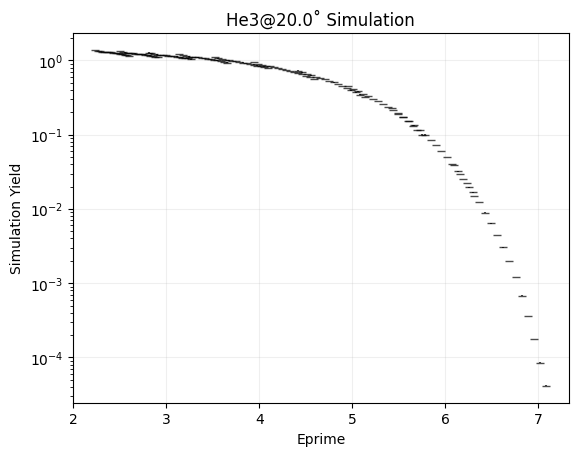

In [17]:
#Read the Cross-section table
V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor(f"/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xsec_tables/xem2_emc_rc_{nsimstring}22_hms.out")

Eprime_dict = {}
delta_dict = {}
xsec_array = {}
mc_scale = {}
thetadict = {}
ytar_weight = {}
ytarcut = {}
jacobian_weight = {}
delta_weight = {}
idang = int(dang)

for momentum in dmom:
    mom_str = str(momentum).replace('-', '').replace('.', 'p').rstrip('0')
    # mom_str = str(momentum).replace('-', '').replace('.', 'p')
    # filepath = f"/Volumes/smriti/xem2/worksim/hms_mc_{nsimstring}_{idang}degm{mom_str}.root"
    # New MC files
    filepath = f"/Volumes/smriti/xem2/worksim/hms_{idang}deg_{mom_str}gev_{nsimstring}.root"

    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h10"]

    # Load the branches
    electrons = tree.arrays(["hsdeltai", "hsytar", "hsyptari", "hsxptari", "stop_id"], library = 'np')    
    nentries = len(electrons["hsdeltai"])

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdeltai"]) <= 8) & \
            (np.abs(electrons["hsyptari"]) < 0.032) & \
            (np.abs(electrons["hsxptari"]) < 0.085) & \
            (electrons["stop_id"] == 0)

    # New delta correction
    # Perform the delta correction
    electrons["hsdeltai"] = (0.990337 * electrons["hsdeltai"]) - 0.00236077 * (electrons["hsdeltai"]**2) + 0.000286814 * (electrons["hsdeltai"]**3) + 2.09878E-6 * (electrons["hsdeltai"]**4) - 2.48674E-6 * (electrons["hsdeltai"]**5) + 1.8646E-7 * (electrons["hsdeltai"]**6)

    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdeltai"][mc_cut]
    hsyptar_cut = electrons["hsyptari"][mc_cut]
    hsxptar_cut = electrons["hsxptari"][mc_cut]
    hsytar_cut = electrons["hsytar"][mc_cut]

    delta_dict[momentum] = hsdelta_cut

    # Calculate E' and theta (in degrees)
    Eprime_dict[momentum] = momentum * (1 + 0.01 * hsdelta_cut)
    thetarad = np.arccos((cos_ts + hsyptar_cut * sin_ts) / np.sqrt(1 + hsxptar_cut * hsxptar_cut + hsyptar_cut * hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)

    # Calculate the ytar acceptance correction factor
    ytar_weight[momentum] = -0.00812174 * hsytar_cut**2 - 0.0000415678 * hsytar_cut + 1.00021
    ytarcut[momentum] = hsytar_cut

    # MC Jacobian
    jacobian_weight[momentum] = np.power((1 + np.power(hsxptar_cut, 2) + np.power(hsyptar_cut, 2)), -1.5)
        
    # Perform the interpolation
    points_ntg = np.array([V2, V3]).T # Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime_dict[momentum], thetadeg))
    xsec_array[momentum] = griddata(points_ntg, V9, points_to_interpolate, method = 'linear') # Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section (V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section
    mc_scale[momentum] = (lumin * domega * (ep_max[momentum] - ep_min[momentum])) / nentries         # Calculate the scale for simulation
    print(f"Scale for {momentum} GeV: {mc_scale[momentum]}")
    thetadict[momentum] = thetadeg

hsdelta_min, hsdelta_max = np.min(delta_dict[2.42]), np.max(delta_dict[2.42])
print("Should be -8 and +8", hsdelta_min, hsdelta_max)
hsdelta_binedges = np.linspace(hsdelta_min, hsdelta_max, bin_per_mom + 1)

# This function returns 2 arrays: bin counts (the counts in each bin taking weights into account) and bin edges (the edges of the bins)
bin_edges_delta_2p42 = np.histogram(delta_dict[2.42], weights = xsec_array[2.42] * mc_scale[2.42], bins = hsdelta_binedges)[1]
bin_edges_delta_2p71 = np.histogram(delta_dict[2.71], weights = xsec_array[2.71] * mc_scale[2.71], bins = hsdelta_binedges)[1]
bin_edges_delta_3p04 = np.histogram(delta_dict[3.04], weights = xsec_array[3.04] * mc_scale[3.04], bins = hsdelta_binedges)[1]
bin_edges_delta_3p4 = np.histogram(delta_dict[3.4], weights = xsec_array[3.4] * mc_scale[3.4], bins = hsdelta_binedges)[1]
bin_edges_delta_3p81 = np.histogram(delta_dict[3.81], weights = xsec_array[3.81] * mc_scale[3.81], bins = hsdelta_binedges)[1]
bin_edges_delta_4p27 = np.histogram(delta_dict[4.27], weights = xsec_array[4.27] * mc_scale[4.27], bins = hsdelta_binedges)[1]
bin_edges_delta_4p78 = np.histogram(delta_dict[4.78], weights = xsec_array[4.78] * mc_scale[4.78], bins = hsdelta_binedges)[1]
bin_edges_delta_5p36 = np.histogram(delta_dict[5.36], weights = xsec_array[5.36] * mc_scale[5.36], bins = hsdelta_binedges)[1]
bin_edges_delta_5p878 = np.histogram(delta_dict[5.878], weights = xsec_array[5.878] * mc_scale[5.878], bins = hsdelta_binedges)[1]
bin_edges_delta_6p6 = np.histogram(delta_dict[6.6], weights = xsec_array[6.6] * mc_scale[6.6], bins = hsdelta_binedges)[1]

# Gets the yield and yield error
bin_counts_eprime_2p42_mc_ntg, bin_errors_eprime_2p42_mc_ntg = mchist_from_array(delta_dict[2.42], xsec_array[2.42] * mc_scale[2.42] * ytar_weight[2.42] * jacobian_weight[2.42], hsdelta_binedges)
bin_counts_eprime_2p71_mc_ntg, bin_errors_eprime_2p71_mc_ntg = mchist_from_array(delta_dict[2.71], xsec_array[2.71] * mc_scale[2.71] * ytar_weight[2.71] * jacobian_weight[2.71], hsdelta_binedges)
bin_counts_eprime_3p04_mc_ntg, bin_errors_eprime_3p04_mc_ntg = mchist_from_array(delta_dict[3.04], xsec_array[3.04] * mc_scale[3.04] * ytar_weight[3.04] * jacobian_weight[3.04], hsdelta_binedges)
bin_counts_eprime_3p4_mc_ntg, bin_errors_eprime_3p4_mc_ntg = mchist_from_array(delta_dict[3.4], xsec_array[3.4] * mc_scale[3.4] * ytar_weight[3.4] * jacobian_weight[3.4], hsdelta_binedges)
bin_counts_eprime_3p81_mc_ntg, bin_errors_eprime_3p81_mc_ntg = mchist_from_array(delta_dict[3.81], xsec_array[3.81] * mc_scale[3.81] * ytar_weight[3.81] * jacobian_weight[3.81], hsdelta_binedges)
bin_counts_eprime_4p27_mc_ntg, bin_errors_eprime_4p27_mc_ntg = mchist_from_array(delta_dict[4.27], xsec_array[4.27] * mc_scale[4.27] * ytar_weight[4.27] * jacobian_weight[4.27], hsdelta_binedges)
bin_counts_eprime_4p78_mc_ntg, bin_errors_eprime_4p78_mc_ntg = mchist_from_array(delta_dict[4.78], xsec_array[4.78] * mc_scale[4.78] * ytar_weight[4.78] * jacobian_weight[4.78], hsdelta_binedges)
bin_counts_eprime_5p36_mc_ntg, bin_errors_eprime_5p36_mc_ntg = mchist_from_array(delta_dict[5.36], xsec_array[5.36] * mc_scale[5.36] * ytar_weight[5.36] * jacobian_weight[5.36], hsdelta_binedges)
bin_counts_eprime_5p878_mc_ntg, bin_errors_eprime_5p878_mc_ntg = mchist_from_array(delta_dict[5.878], xsec_array[5.878] * mc_scale[5.878] * ytar_weight[5.878] * jacobian_weight[5.878], hsdelta_binedges)
bin_counts_eprime_6p6_mc_ntg, bin_errors_eprime_6p6_mc_ntg = mchist_from_array(delta_dict[6.6], xsec_array[6.6] * mc_scale[6.6] * ytar_weight[6.6] * jacobian_weight[6.6], hsdelta_binedges)

bin_centers_delta_2p42 = (bin_edges_delta_2p42[:-1] + bin_edges_delta_2p42[1:]) / 2
bin_centers_delta_2p71 = (bin_edges_delta_2p71[:-1] + bin_edges_delta_2p71[1:]) / 2
bin_centers_delta_3p04 = (bin_edges_delta_3p04[:-1] + bin_edges_delta_3p04[1:]) / 2
bin_centers_delta_3p4 = (bin_edges_delta_3p4[:-1] + bin_edges_delta_3p4[1:]) / 2
bin_centers_delta_3p81 = (bin_edges_delta_3p81[:-1] + bin_edges_delta_3p81[1:]) / 2
bin_centers_delta_4p27 = (bin_edges_delta_4p27[:-1] + bin_edges_delta_4p27[1:]) / 2
bin_centers_delta_4p78 = (bin_edges_delta_4p78[:-1] + bin_edges_delta_4p78[1:]) / 2
bin_centers_delta_5p36 = (bin_edges_delta_5p36[:-1] + bin_edges_delta_5p36[1:]) / 2
bin_centers_delta_5p878 = (bin_edges_delta_5p878[:-1] + bin_edges_delta_5p878[1:]) / 2
bin_centers_delta_6p6 = (bin_edges_delta_6p6[:-1] + bin_edges_delta_6p6[1:]) / 2

binned_eprime_bin_centers_2p42_mc_ntg = 2.42 * (1 + 0.01 * bin_centers_delta_2p42)
binned_eprime_bin_centers_2p71_mc_ntg = 2.71 * (1 + 0.01 * bin_centers_delta_2p71)
binned_eprime_bin_centers_3p04_mc_ntg = 3.04 * (1 + 0.01 * bin_centers_delta_3p04)
binned_eprime_bin_centers_3p4_mc_ntg = 3.4 * (1 + 0.01 * bin_centers_delta_3p4)
binned_eprime_bin_centers_3p81_mc_ntg = 3.81 * (1 + 0.01 * bin_centers_delta_3p81)
binned_eprime_bin_centers_4p27_mc_ntg = 4.27 * (1 + 0.01 * bin_centers_delta_4p27)
binned_eprime_bin_centers_4p78_mc_ntg = 4.78 * (1 + 0.01 * bin_centers_delta_4p78)
binned_eprime_bin_centers_5p36_mc_ntg = 5.36 * (1 + 0.01 * bin_centers_delta_5p36)
binned_eprime_bin_centers_5p878_mc_ntg = 5.878 * (1 + 0.01 * bin_centers_delta_5p878)
binned_eprime_bin_centers_6p6_mc_ntg = 6.6 * (1 + 0.01 * bin_centers_delta_6p6)

#Plotting the histogram with error bars
fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_2p42_mc_ntg, bin_counts_eprime_2p42_mc_ntg, yerr = bin_errors_eprime_2p42_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.42 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p71_mc_ntg, bin_counts_eprime_2p71_mc_ntg, yerr = bin_errors_eprime_2p71_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 2.71 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p04_mc_ntg, bin_counts_eprime_3p04_mc_ntg, yerr = bin_errors_eprime_3p04_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 3.04 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p4_mc_ntg, bin_counts_eprime_3p4_mc_ntg, yerr = bin_errors_eprime_3p4_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 3.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p81_mc_ntg, bin_counts_eprime_3p81_mc_ntg, yerr = bin_errors_eprime_3p81_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 3.81 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p27_mc_ntg, bin_counts_eprime_4p27_mc_ntg, yerr = bin_errors_eprime_4p27_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 4.27 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p78_mc_ntg, bin_counts_eprime_4p78_mc_ntg, yerr = bin_errors_eprime_4p78_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 4.78 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p36_mc_ntg, bin_counts_eprime_5p36_mc_ntg, yerr = bin_errors_eprime_5p36_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 5.36 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p878_mc_ntg, bin_counts_eprime_5p878_mc_ntg, yerr = bin_errors_eprime_5p878_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 5.878 GeV')
ax2.errorbar(binned_eprime_bin_centers_6p6_mc_ntg, bin_counts_eprime_6p6_mc_ntg, yerr = bin_errors_eprime_6p6_mc_ntg, fmt = '_', color = 'black', alpha = 0.7, label = 'Sim 6.6 GeV')
ax2.grid(alpha = 0.2)
ax2.set_xlabel('Eprime')
ax2.set_ylabel('Simulation Yield')
ax2.set_yscale('log')
# ax.legend() 
ax2.set_title(f'{ntg}@{dang}˚ Simulation')
# fig2.savefig(f'{folder}/eprime_{ntg}_{dang}_{start_time:.0f}.pdf')                   

<h1 align="center">DATA/SIMULATION YIELD RATIO FOR NTG</h1>


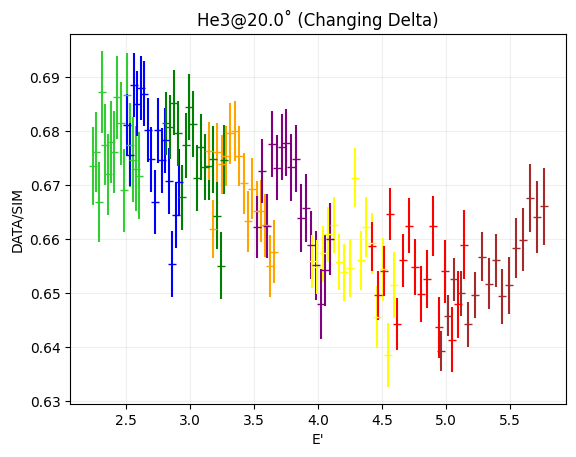

In [18]:
ratio_eprime_2p42_ntg = subtracted_bin_contents_2p42_ntg / bin_counts_eprime_2p42_mc_ntg
ratio_eprime_2p71_ntg = subtracted_bin_contents_2p71_ntg / bin_counts_eprime_2p71_mc_ntg
ratio_eprime_3p04_ntg = subtracted_bin_contents_3p04_ntg / bin_counts_eprime_3p04_mc_ntg
ratio_eprime_3p4_ntg = subtracted_bin_contents_3p4_ntg / bin_counts_eprime_3p4_mc_ntg
ratio_eprime_3p81_ntg = subtracted_bin_contents_3p81_ntg / bin_counts_eprime_3p81_mc_ntg
ratio_eprime_4p27_ntg = subtracted_bin_contents_4p27_ntg / bin_counts_eprime_4p27_mc_ntg
ratio_eprime_4p78_ntg = subtracted_bin_contents_4p78_ntg / bin_counts_eprime_4p78_mc_ntg
ratio_eprime_5p36_ntg = subtracted_bin_contents_5p36_ntg / bin_counts_eprime_5p36_mc_ntg
ratio_eprime_5p878_ntg = subtracted_bin_contents_5p878_ntg / bin_counts_eprime_5p878_mc_ntg
ratio_eprime_6p6_ntg = subtracted_bin_contents_6p6_ntg / bin_counts_eprime_6p6_mc_ntg

# Add errors in quadrature. First is data and second is MC
ratio_errors_2p42_ntg = ratio_eprime_2p42_ntg * np.sqrt((subtracted_bin_errors_2p42_ntg / subtracted_bin_contents_2p42_ntg)**2 + (bin_errors_eprime_2p42_mc_ntg / bin_counts_eprime_2p42_mc_ntg)**2)
ratio_errors_2p71_ntg = ratio_eprime_2p71_ntg * np.sqrt((subtracted_bin_errors_2p71_ntg / subtracted_bin_contents_2p71_ntg)**2 + (bin_errors_eprime_2p71_mc_ntg / bin_counts_eprime_2p71_mc_ntg)**2)
ratio_errors_3p04_ntg = ratio_eprime_3p04_ntg * np.sqrt((subtracted_bin_errors_3p04_ntg / subtracted_bin_contents_3p04_ntg)**2 + (bin_errors_eprime_3p04_mc_ntg / bin_counts_eprime_3p04_mc_ntg)**2)
ratio_errors_3p4_ntg = ratio_eprime_3p4_ntg * np.sqrt((subtracted_bin_errors_3p4_ntg / subtracted_bin_contents_3p4_ntg)**2 + (bin_errors_eprime_3p4_mc_ntg / bin_counts_eprime_3p4_mc_ntg)**2)
ratio_errors_3p81_ntg = ratio_eprime_3p81_ntg * np.sqrt((subtracted_bin_errors_3p81_ntg / subtracted_bin_contents_3p81_ntg)**2 + (bin_errors_eprime_3p81_mc_ntg / bin_counts_eprime_3p81_mc_ntg)**2)
ratio_errors_4p27_ntg = ratio_eprime_4p27_ntg * np.sqrt((subtracted_bin_errors_4p27_ntg / subtracted_bin_contents_4p27_ntg)**2 + (bin_errors_eprime_4p27_mc_ntg / bin_counts_eprime_4p27_mc_ntg)**2)
ratio_errors_4p78_ntg = ratio_eprime_4p78_ntg * np.sqrt((subtracted_bin_errors_4p78_ntg / subtracted_bin_contents_4p78_ntg)**2 + (bin_errors_eprime_4p78_mc_ntg / bin_counts_eprime_4p78_mc_ntg)**2)
ratio_errors_5p36_ntg = ratio_eprime_5p36_ntg * np.sqrt((subtracted_bin_errors_5p36_ntg / subtracted_bin_contents_5p36_ntg)**2 + (bin_errors_eprime_5p36_mc_ntg / bin_counts_eprime_5p36_mc_ntg)**2)
ratio_errors_5p878_ntg = ratio_eprime_5p878_ntg * np.sqrt((subtracted_bin_errors_5p878_ntg / subtracted_bin_contents_5p878_ntg)**2 + (bin_errors_eprime_5p878_mc_ntg / bin_counts_eprime_5p878_mc_ntg)**2)
ratio_errors_6p6_ntg = ratio_eprime_6p6_ntg * np.sqrt((subtracted_bin_errors_6p6_ntg / subtracted_bin_contents_6p6_ntg)**2 + (bin_errors_eprime_6p6_mc_ntg / bin_counts_eprime_6p6_mc_ntg)**2)

fig2, ax2 = plt.subplots()
ax2.errorbar(binned_eprime_bin_centers_2p42, ratio_eprime_2p42_ntg, yerr = ratio_errors_2p42_ntg, fmt = '_', color = 'limegreen', label = '2.42 GeV')
ax2.errorbar(binned_eprime_bin_centers_2p71, ratio_eprime_2p71_ntg, yerr = ratio_errors_2p71_ntg, fmt = '_', color = 'blue', label = '2.71 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p04, ratio_eprime_3p04_ntg, yerr = ratio_errors_3p04_ntg, fmt = '_', color = 'green', label = '3.04 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p4, ratio_eprime_3p4_ntg, yerr = ratio_errors_3p4_ntg, fmt = '_', color = 'orange', label = '3.4 GeV')
ax2.errorbar(binned_eprime_bin_centers_3p81, ratio_eprime_3p81_ntg, yerr = ratio_errors_3p81_ntg, fmt = '_', color = 'purple', label = '3.81 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p27, ratio_eprime_4p27_ntg, yerr = ratio_errors_4p27_ntg, fmt = '_', color = 'yellow', label = '4.27 GeV')
ax2.errorbar(binned_eprime_bin_centers_4p78, ratio_eprime_4p78_ntg, yerr = ratio_errors_4p78_ntg, fmt = '_', color = 'red', label = '4.78 GeV')
ax2.errorbar(binned_eprime_bin_centers_5p36, ratio_eprime_5p36_ntg, yerr = ratio_errors_5p36_ntg, fmt = '_', color = 'brown', label = '5.36 GeV')
# ax2.errorbar(binned_eprime_bin_centers_5p878, ratio_eprime_5p878_ntg, yerr = ratio_errors_5p878_ntg, fmt = '_', color = 'cyan', label = '5.878 GeV')
# ax2.errorbar(binned_eprime_bin_centers_6p6, ratio_eprime_6p6_ntg, yerr = ratio_errors_6p6_ntg, fmt = '_', color = 'lightgreen', label = '6.6 GeV')
ax2.set_xlabel('E\'')
ax2.set_ylabel('DATA/SIM')
ax2.set_title(f'{ntg}@{dang}˚ (Changing Delta)')
ax2.grid(alpha = 0.2)
# ax2.set_ylim(0.5, 1.1)
# fig2.savefig(f'{folder}/yieldratio_{ntg}_{dang}_{start_time:.0f}.pdf')

In [19]:
print(f"bin_counts_eprime_2p42_mc_ntg: {bin_counts_eprime_2p42_mc_ntg}")
print(f"bin_counts_eprime_2p71_mc_ntg: {bin_counts_eprime_2p71_mc_ntg}")
print(f"bin_counts_eprime_3p04_mc_ntg: {bin_counts_eprime_3p04_mc_ntg}")
print(f"bin_counts_eprime_3p4_mc_ntg: {bin_counts_eprime_3p4_mc_ntg}")
print(f"bin_counts_eprime_3p81_mc_ntg: {bin_counts_eprime_3p81_mc_ntg}")
print(f"bin_counts_eprime_4p27_mc_ntg: {bin_counts_eprime_4p27_mc_ntg}")
print(f"bin_counts_eprime_4p78_mc_ntg: {bin_counts_eprime_4p78_mc_ntg}")
print(f"bin_counts_eprime_5p36_mc_ntg: {bin_counts_eprime_5p36_mc_ntg}")
print(f"bin_counts_eprime_5p878_mc_ntg: {bin_counts_eprime_5p878_mc_ntg}")
print(f"bin_counts_eprime_6p6_mc_ntg: {bin_counts_eprime_6p6_mc_ntg}")

bin_counts_eprime_2p42_mc_ntg: [1.37952805 1.33805587 1.32518075 1.31056174 1.30298581 1.29759551
 1.29102134 1.28176855 1.2673057  1.25939837 1.24517617 1.22926494
 1.21741448 1.19627934 1.17920201 1.1550569 ]
bin_counts_eprime_2p71_mc_ntg: [1.33133979 1.29567917 1.27470839 1.25790896 1.25188746 1.24359058
 1.23602801 1.2325173  1.2268572  1.20550822 1.20000826 1.18065346
 1.16097098 1.15437412 1.12224729 1.1038167 ]
bin_counts_eprime_3p04_mc_ntg: [1.27724495 1.2388205  1.21558893 1.20011779 1.19448737 1.1799775
 1.18002034 1.15881016 1.1550788  1.14220652 1.12710894 1.10875217
 1.09226595 1.07366659 1.06176859 1.03058451]
bin_counts_eprime_3p4_mc_ntg: [1.20448322 1.16883633 1.14775595 1.12540804 1.11265058 1.10659373
 1.09478063 1.08140971 1.07029368 1.05141437 1.03912919 1.01576624
 0.99915511 0.9808006  0.95484853 0.93490063]
bin_counts_eprime_3p81_mc_ntg: [1.09852518 1.06147608 1.04442282 1.01653139 0.99964286 0.98557896
 0.97298027 0.95262357 0.93519886 0.91676573 0.90064377 0.87

<h1 align="center">BORN CROSS SECTION CALCULATION FOR NTG</h1>


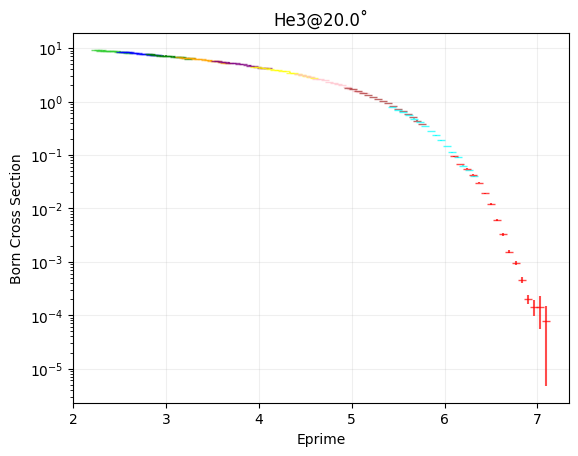

In [20]:
# Get points to interpolate based on angle and E'. Common for ntg and dtg
points_to_interpolate_2p42 = np.column_stack((binned_eprime_bin_centers_2p42, np.full(len(binned_eprime_bin_centers_2p42), dang)))
points_to_interpolate_2p71 = np.column_stack((binned_eprime_bin_centers_2p71, np.full(len(binned_eprime_bin_centers_2p71), dang)))
points_to_interpolate_3p04 = np.column_stack((binned_eprime_bin_centers_3p04, np.full(len(binned_eprime_bin_centers_3p04), dang)))
points_to_interpolate_3p4 = np.column_stack((binned_eprime_bin_centers_3p4, np.full(len(binned_eprime_bin_centers_3p4), dang)))
points_to_interpolate_3p81 = np.column_stack((binned_eprime_bin_centers_3p81, np.full(len(binned_eprime_bin_centers_3p81), dang)))
points_to_interpolate_4p27 = np.column_stack((binned_eprime_bin_centers_4p27, np.full(len(binned_eprime_bin_centers_4p27), dang)))
points_to_interpolate_4p78 = np.column_stack((binned_eprime_bin_centers_4p78, np.full(len(binned_eprime_bin_centers_4p78), dang)))
points_to_interpolate_5p36 = np.column_stack((binned_eprime_bin_centers_5p36, np.full(len(binned_eprime_bin_centers_5p36), dang)))
points_to_interpolate_5p878 = np.column_stack((binned_eprime_bin_centers_5p878, np.full(len(binned_eprime_bin_centers_5p878), dang)))
points_to_interpolate_6p6 = np.column_stack((binned_eprime_bin_centers_6p6, np.full(len(binned_eprime_bin_centers_6p6), dang)))

# Interpolate again to get model Born cross-section
born_xsec_array_2p42_ntg = griddata(points_ntg, V6, points_to_interpolate_2p42, method = 'linear') # points is just the whole stack of 2D array of [E', theta] from the table
born_xsec_array_2p71_ntg = griddata(points_ntg, V6, points_to_interpolate_2p71, method = 'linear')
born_xsec_array_3p04_ntg = griddata(points_ntg, V6, points_to_interpolate_3p04, method = 'linear')
born_xsec_array_3p4_ntg = griddata(points_ntg, V6, points_to_interpolate_3p4, method = 'linear')
born_xsec_array_3p81_ntg = griddata(points_ntg, V6, points_to_interpolate_3p81, method = 'linear')
born_xsec_array_4p27_ntg = griddata(points_ntg, V6, points_to_interpolate_4p27, method = 'linear')
born_xsec_array_4p78_ntg = griddata(points_ntg, V6, points_to_interpolate_4p78, method = 'linear')
born_xsec_array_5p36_ntg = griddata(points_ntg, V6, points_to_interpolate_5p36, method = 'linear')
born_xsec_array_5p878_ntg = griddata(points_ntg, V6, points_to_interpolate_5p878, method = 'linear')
born_xsec_array_6p6_ntg = griddata(points_ntg, V6, points_to_interpolate_6p6, method = 'linear')
# print("Length of born_xsec_array", len(born_xsec_array))

# Get the QE piece
qe_array_2p42_ntg = griddata(points_ntg, V8, points_to_interpolate_2p42, method = 'linear')
qe_array_2p71_ntg = griddata(points_ntg, V8, points_to_interpolate_2p71, method = 'linear')
qe_array_3p04_ntg = griddata(points_ntg, V8, points_to_interpolate_3p04, method = 'linear')
qe_array_3p4_ntg = griddata(points_ntg, V8, points_to_interpolate_3p4, method = 'linear')
qe_array_3p81_ntg = griddata(points_ntg, V8, points_to_interpolate_3p81, method = 'linear')
qe_array_4p27_ntg = griddata(points_ntg, V8, points_to_interpolate_4p27, method = 'linear')
qe_array_4p78_ntg = griddata(points_ntg, V8, points_to_interpolate_4p78, method = 'linear')
qe_array_5p36_ntg = griddata(points_ntg, V8, points_to_interpolate_5p36, method = 'linear')
qe_array_5p878_ntg = griddata(points_ntg, V8, points_to_interpolate_5p878, method = 'linear')
qe_array_6p6_ntg = griddata(points_ntg, V8, points_to_interpolate_6p6, method = 'linear')

# Interpolate 3rd time to get Coulomb correction factor
ccf_2p42_ntg = griddata(points_ntg, V13, points_to_interpolate_2p42, method = 'linear')
ccf_2p71_ntg = griddata(points_ntg, V13, points_to_interpolate_2p71, method = 'linear')
ccf_3p04_ntg = griddata(points_ntg, V13, points_to_interpolate_3p04, method = 'linear')
ccf_3p4_ntg = griddata(points_ntg, V13, points_to_interpolate_3p4, method = 'linear')
ccf_3p81_ntg = griddata(points_ntg, V13, points_to_interpolate_3p81, method = 'linear')
ccf_4p27_ntg = griddata(points_ntg, V13, points_to_interpolate_4p27, method = 'linear')
ccf_4p78_ntg = griddata(points_ntg, V13, points_to_interpolate_4p78, method = 'linear')
ccf_5p36_ntg = griddata(points_ntg, V13, points_to_interpolate_5p36, method = 'linear')
ccf_5p878_ntg = griddata(points_ntg, V13, points_to_interpolate_5p878, method = 'linear')
ccf_6p6_ntg = griddata(points_ntg, V13, points_to_interpolate_6p6, method = 'linear')

fig3, ax3 = plt.subplots()
# Calculate the data Born cross-section and apply Coloumb corrections
born_cross_2p42_ntg = ratio_eprime_2p42_ntg * born_xsec_array_2p42_ntg * ccf_2p42_ntg
born_cross_2p71_ntg = ratio_eprime_2p71_ntg * born_xsec_array_2p71_ntg * ccf_2p71_ntg
born_cross_3p04_ntg = ratio_eprime_3p04_ntg * born_xsec_array_3p04_ntg * ccf_3p04_ntg
born_cross_3p4_ntg= ratio_eprime_3p4_ntg * born_xsec_array_3p4_ntg * ccf_3p4_ntg
born_cross_3p81_ntg = ratio_eprime_3p81_ntg * born_xsec_array_3p81_ntg * ccf_3p81_ntg
born_cross_4p27_ntg = ratio_eprime_4p27_ntg * born_xsec_array_4p27_ntg * ccf_4p27_ntg
born_cross_4p78_ntg = ratio_eprime_4p78_ntg * born_xsec_array_4p78_ntg * ccf_4p78_ntg
born_cross_5p36_ntg = ratio_eprime_5p36_ntg * born_xsec_array_5p36_ntg * ccf_5p36_ntg
born_cross_5p878_ntg = ratio_eprime_5p878_ntg * born_xsec_array_5p878_ntg * ccf_5p878_ntg
born_cross_6p6_ntg= ratio_eprime_6p6_ntg * born_xsec_array_6p6_ntg * ccf_6p6_ntg

# print("Length of born_cross", len(born_cross))
# print("Born cross section", born_cross)
born_errors_2p42_ntg = born_cross_2p42_ntg * ratio_errors_2p42_ntg
born_errors_2p71_ntg = born_cross_2p71_ntg * ratio_errors_2p71_ntg
born_errors_3p04_ntg = born_cross_3p04_ntg * ratio_errors_3p04_ntg
born_errors_3p4_ntg = born_cross_3p4_ntg * ratio_errors_3p4_ntg
born_errors_3p81_ntg = born_cross_3p81_ntg * ratio_errors_3p81_ntg
born_errors_4p27_ntg = born_cross_4p27_ntg * ratio_errors_4p27_ntg
born_errors_4p78_ntg = born_cross_4p78_ntg * ratio_errors_4p78_ntg
born_errors_5p36_ntg = born_cross_5p36_ntg * ratio_errors_5p36_ntg
born_errors_5p878_ntg = born_cross_5p878_ntg * ratio_errors_5p878_ntg
born_errors_6p6_ntg = born_cross_6p6_ntg * ratio_errors_6p6_ntg

ax3.errorbar(binned_eprime_bin_centers_2p42, born_cross_2p42_ntg, yerr = born_errors_2p42_ntg, fmt = '_', alpha = 0.7, color = 'limegreen', label = '2.42 GeV')
ax3.errorbar(binned_eprime_bin_centers_2p71, born_cross_2p71_ntg, yerr = born_errors_2p71_ntg, fmt = '_', alpha = 0.7, color = 'blue', label = '2.71 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p04, born_cross_3p04_ntg, yerr = born_errors_3p04_ntg, fmt = '_', alpha = 0.7, color = 'green', label = '3.04 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p4, born_cross_3p4_ntg, yerr = born_errors_3p4_ntg, fmt = '_', alpha = 0.7, color = 'orange', label = '3.4 GeV')
ax3.errorbar(binned_eprime_bin_centers_3p81, born_cross_3p81_ntg, yerr = born_errors_3p81_ntg, fmt = '_', alpha = 0.7, color = 'purple', label = '3.81 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p27, born_cross_4p27_ntg, yerr = born_errors_4p27_ntg, fmt = '_', alpha = 0.7, color = 'yellow', label = '4.27 GeV')
ax3.errorbar(binned_eprime_bin_centers_4p78, born_cross_4p78_ntg, yerr = born_errors_4p78_ntg, fmt = '_', alpha = 0.7, color = 'pink', label = '4.78 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p36, born_cross_5p36_ntg, yerr = born_errors_5p36_ntg, fmt = '_', alpha = 0.7, color = 'brown', label = '5.36 GeV')
ax3.errorbar(binned_eprime_bin_centers_5p878, born_cross_5p878_ntg, yerr = born_errors_5p878_ntg, fmt = '_', alpha = 0.7, color = 'cyan', label = '5.878 GeV')
ax3.errorbar(binned_eprime_bin_centers_6p6, born_cross_6p6_ntg, yerr = born_errors_6p6_ntg, fmt = '_', alpha = 0.7, color = 'red', label = '6.6 GeV')
ax3.set_xlabel('Eprime')
ax3.set_ylabel('Born Cross Section')
ax3.set_title(f'{ntg}@{dang}˚')
ax3.set_yscale('log')
#ax3.legend()
ax3.grid(alpha = 0.2)
# fig3.savefig(f'{folder}/xsec_{ntg}_{dang}_{start_time:.0f}.pdf')

In [21]:
minutes = (time.time() - start_time) / 60
print(f"Time taken: {minutes:.2f} minutes")
baja()

Time taken: 4.25 minutes
